In [1]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import datetime
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
import numpy as np
import cv2
from PIL import Image

2024-01-25 11:20:02.683054: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 11:20:03.083946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 11:20:03.084287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 11:20:03.150920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 11:20:03.305776: I tensorflow/core/platform/cpu_feature_guar

In [32]:
# Folder structure is like this:
# ./Cortex/good
# ./Cortex/bad

In [33]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU available.")
else:
    print("No GPU available, consider installing a compatible GPU version of TensorFlow.")

GPU available.


In [34]:
# Define the path to your dataset
data_dir = "./Backup/train"
test_dir = "./Backup/test"
# Load the image paths and labels
image_paths = []
labels = []
test_image_paths = []
test_labels = []

In [35]:
for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            image_path = os.path.join(label_path, image)
            image_paths.append(image_path)
            labels.append(1 if label == 'good' else 0)  # Assign 1 to 'good' and 0 to 'bad'

for test_label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, test_label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            test_image_path = os.path.join(label_path, image)
            test_image_paths.append(test_image_path)
            test_labels.append(int(1) if test_label == 'good' else int(0))  # Assign 1 to 'good' and 0 to 'bad'

In [36]:
# Define the ImageDataGenerator with reduced data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # Reduced rotation range
    # width_shift_range=0.1,       # Reduced width shift range
    # height_shift_range=0.1,      # Reduced height shift range
    # shear_range=0.1,             # Reduced shear intensity
    zoom_range=0.05,              # Reduced zoom range
    brightness_range=[0.2, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [37]:
# Assuming X_train_paths and y_train are already defined
# Split the dataset into training and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.10, random_state=42, stratify=labels
)

# Convert the image paths to numeric values (you might need to use an appropriate encoding)
X_train_paths_numeric = np.arange(len(X_train_paths))

# Apply SMOTE to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_paths_numeric.reshape(-1, 1), y_train)

# Apply ENN to the resampled data
enn = EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=3)
X_train_resampled, y_train_resampled = enn.fit_resample(X_train_resampled.reshape(-1, 1), y_train_resampled)

# Convert the resampled data to DataFrame
df_resampled = pd.DataFrame({'index': X_train_resampled.flatten(), 'label': y_train_resampled})
df_resampled['path'] = df_resampled['index'].apply(lambda x: X_train_paths[x])

# Further split the training set into training and validation sets
X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(
    df_resampled['path'], df_resampled['label'], test_size=0.10, random_state=42, stratify=df_resampled['label']
)

In [38]:
# # Convert labels to strings in the lists
# y_train = [str(label) for label in y_train]
y_train_resampled = [str(label) for label in y_train_resampled]
y_val = [str(label) for label in y_val]
y_val_resampled = [str(label) for label in y_val_resampled]
y_test = [str(label) for label in test_labels]

In [39]:
# Define the training generator with SMOTE
train_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'path': X_train_resampled, 'label': y_train_resampled}),
    x_col="path",
    y_col="label",
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'path': X_val_paths, 'label': y_val}),
    x_col="path",
    y_col="label",
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'path': test_image_paths, 'label': y_test}),
    x_col="path",
    y_col="label",
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 789 validated image filenames belonging to 2 classes.
Found 90 validated image filenames belonging to 2 classes.
Found 91 validated image filenames belonging to 2 classes.


In [59]:
VGG16 = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
VGG16.trainable = False

In [60]:
# Create your custom model on top of VGG16
model = Sequential()

model.add(VGG16)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

In [40]:
################################ I used this part to continue from a checkpoint ##############################################
# Load the weights from the best checkpoint
model = tf.keras.models.load_model('./models/good_clip_bad_clip_V15_least_loss')
##############################################################################################################################

In [62]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [64]:
# Learning rate scheduler
def scheduler(epoch, lr):
    initial_learning_rate = 0.0001
    decay_rate = 0.95
    if epoch < 3:
        return lr
    else:
        return initial_learning_rate * decay_rate ** (epoch - 3)

In [65]:
lr_scheduler = LearningRateScheduler(scheduler)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)

In [66]:
# ModelCheckpoint callback for saving the entire model
model_filepath = f'./weights/best_model.h5'
model_save_callback = ModelCheckpoint(
    filepath=model_filepath,
    save_weights_only=False,  # Save the entire model
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [67]:
# CSVLogger callback for logging metrics
csv_logger_filepath = f'./logs/training_logs_fold.csv'
csv_logger_callback = CSVLogger(csv_logger_filepath)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [68]:
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

In [78]:
# Train the model with GPU acceleration and validation data
history = model.fit(
    train_generator,
    epochs=1000,
    validation_data=validation_generator,
    callbacks=[ early_stopping, lr_scheduler, model_save_callback, csv_logger_callback, tensorboard_callback]
    #class_weight=class_weights early_stopping,
)

Epoch 1/1000
788/789 [============================>.] - ETA: 0s - loss: 0.2573 - accuracy: 0.9099
Epoch 1: val_loss did not improve from 0.13502
789/789 [==============================] - 16s 20ms/step - loss: 0.2571 - accuracy: 0.9100 - val_loss: 0.1483 - val_accuracy: 0.9778 - lr: 3.3487e-08
Epoch 2/1000
786/789 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.9071
Epoch 2: val_loss did not improve from 0.13502
789/789 [==============================] - 15s 18ms/step - loss: 0.2811 - accuracy: 0.9049 - val_loss: 0.1922 - val_accuracy: 0.9444 - lr: 3.3487e-08
Epoch 3/1000
786/789 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.8969
Epoch 3: val_loss did not improve from 0.13502
789/789 [==============================] - 15s 19ms/step - loss: 0.2675 - accuracy: 0.8973 - val_loss: 0.1866 - val_accuracy: 0.9333 - lr: 3.3487e-08
Epoch 4/1000
786/789 [============================>.] - ETA: 0s - loss: 0.2723 - accuracy: 0.9046
Epoch 4: val_loss

In [79]:
# Extract the training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

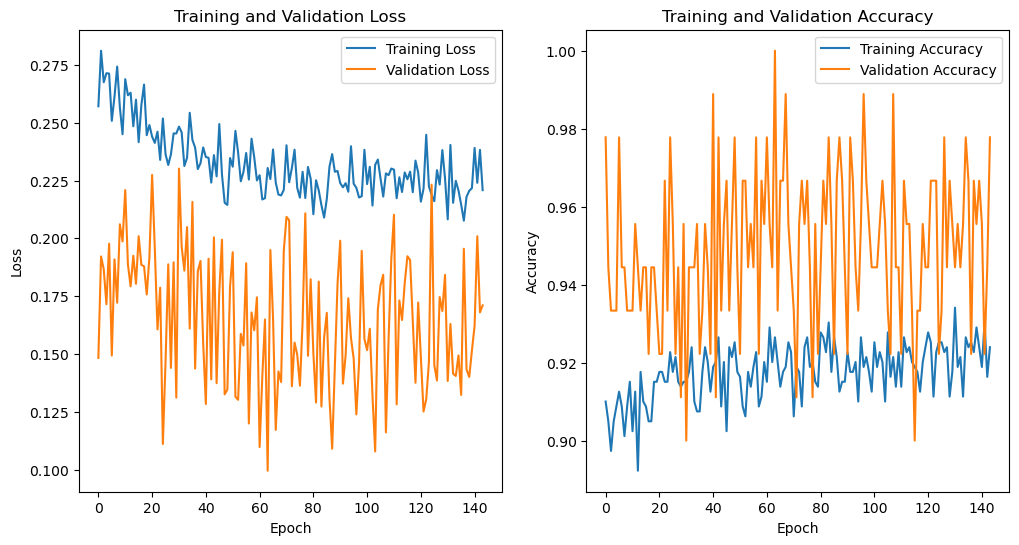

In [80]:
# Plot training and validation history including test accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [81]:
model.save("./models/good_clip_bad_clip_V15_least_loss")

INFO:tensorflow:Assets written to: ./models/good_clip_bad_clip_V15_least_loss\assets


INFO:tensorflow:Assets written to: ./models/good_clip_bad_clip_V15_least_loss\assets


In [41]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

91/91 [==============================] - 2s 16ms/step - loss: 0.3792 - accuracy: 0.8022
Test Accuracy: 80.22%


In [42]:
# Predictions for evaluation metrics
y_true = test_generator.classes
y_pred = model.predict(test_generator)

y_pred_binary = (y_pred > 0.5).astype(int)

91/91 [==============================] - 2s 16ms/step


In [43]:
# Additional Evaluation Metrics
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_binary)
print('Confusion Matrix:')
print(cm)

Precision: 0.9375, Recall: 0.7143, F1 Score: 0.8108
Confusion Matrix:
[[47  2]
 [12 30]]


In [85]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 1.0000


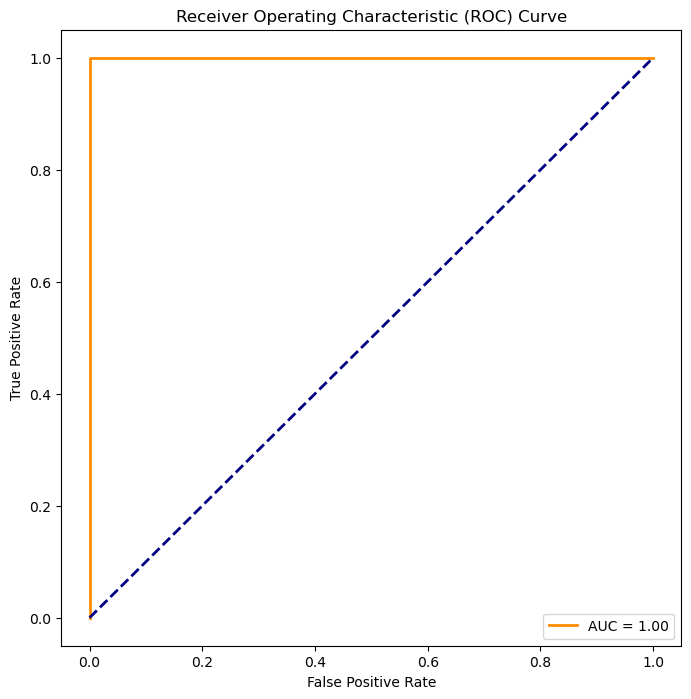

In [86]:
# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [87]:
from tensorflow.keras.preprocessing import image

# Load the image from file
img_path = './Backup/Test/good/a.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data generator used for training
preprocessed_img = datagen.flow(img_array).next()

# Make the prediction
prediction = model.predict(preprocessed_img)

print(prediction)

1/1 [==============================] - 0s 21ms/step
[[0.897972]]
